In [1]:
import numpy as np
from PySDM.physics.constants import si
from simulation import Simulation
from settings import Settings
import plot
from importlib import reload


In [2]:
"""  basic setup for homogeneous freezing of pure-liquid droplets """
"""
Ensemble for:
1. n_sd
2. w
3. r & n_c
Questions:
- where to store backend
"""

n_sd = 100
number_concentration_droplets = 850 / si.cm**3
mean_radius_dry_aerosol= 15 * si.nanometer
updraft = 1 * si.meter / si.second
initial_temperature =  -25. + 273.
time_step = 0.1 * si.second

common = {  "n_sd": n_sd,
    "w_updraft": updraft,
    "T0":  initial_temperature,
    "dt": time_step,
    "N_dv_droplet_distribution": number_concentration_droplets,
    "r_mean_droplet_distribution": mean_radius_dry_aerosol,
    "type_droplet_distribution": "monodisperse",
    "RH_0":0.995,
    "condensation_enable": True,
    "deposition_enable": False,
            }

hom_freezing_types = (  "threshold", "Koop_Correction", "KoopMurray2016", "Koop2000")
simulations = []

for hom_freezing_type in hom_freezing_types:
    setting_dict = {
        **common,
        "hom_freezing": hom_freezing_type,
        }
    simulation = { "settings": setting_dict, }
    simulations.append( simulation )

In [3]:
for simulation in simulations:
    setting = Settings(**simulation["settings"])
    model = Simulation(setting)
    simulation["output"] = model.run()

Setting up simulation with threshold
Starting simulation...
all particles frozen
Setting up simulation with Koop_Correction
Starting simulation...
all particles frozen
Setting up simulation with KoopMurray2016
Starting simulation...
all particles frozen
Setting up simulation with Koop2000
Starting simulation...
all particles frozen


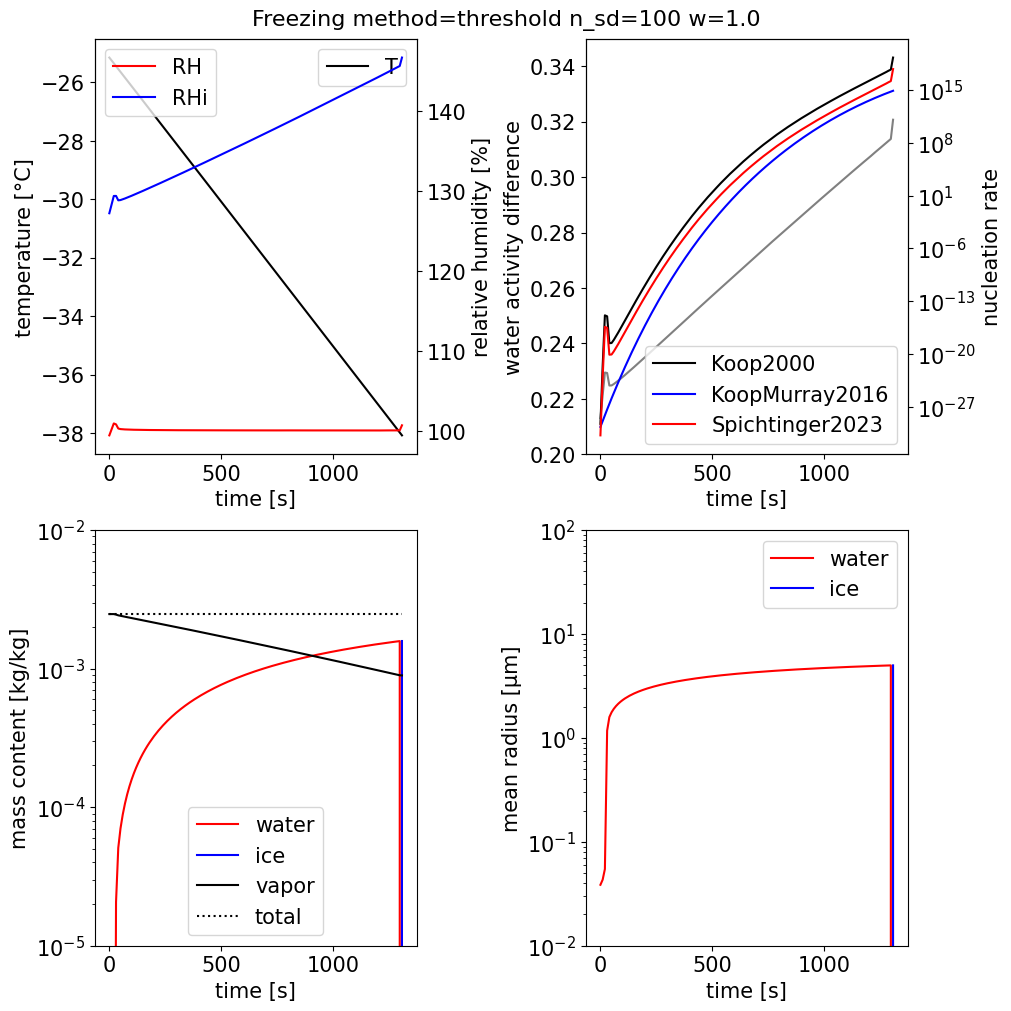

In [4]:
plot.plot_thermodynamics_and_bulk(simulations[0])